In [1]:
import os
import yaml
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from datetime import datetime
from pathlib import Path
from matplotlib.patches import Rectangle

from utils import *

BASE_DIR = Path(os.path.abspath(''))
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

Working directory: c:\Users\Jesper\Documents\GitHub Local\ARFusion


In [2]:
with open('config_MM.yaml' ,'r') as file:
    config = yaml.safe_load(file)

ds_NCBI = pd.read_pickle(config['data']['NCBI']['load_path'])
ds_TESSy = pd.read_pickle(config['data']['TESSy']['load_path'])

In [3]:
def get_pivot_from_processed_datasets(ds, colname = 'phenotypes'):
    df_pivot = ds[colname].explode().value_counts().reset_index()
    df_pivot.columns = ['phenotype', 'count']
    df_pivot['Antibiotic'] = df_pivot['phenotype'].apply(lambda x: x.split('_')[0])
    df_pivot['SR'] = df_pivot['phenotype'].apply(lambda x: x.split('_')[1])
    df_pivot = df_pivot.drop(columns='phenotype').set_index('Antibiotic')
    df_pivot = df_pivot.pivot(columns='SR', values='count').fillna(0)
    df_pivot = df_pivot[['S', 'R']]
    df_pivot[['S_share', 'R_share']] = df_pivot.div(df_pivot.sum(axis=1), axis=0)
    df_pivot['Total'] = df_pivot['S'] + df_pivot['R']
    df_pivot = df_pivot[['Total', 'S', 'R', 'S_share', 'R_share']]
    
    return df_pivot

pivot_TESSy = get_pivot_from_processed_datasets(ds_TESSy)
pivot_NCBI = get_pivot_from_processed_datasets(ds_NCBI)

In [4]:
pivot_NCBI

SR,Total,S,R,S_share,R_share
Antibiotic,,,,,
AMK,3260,3211,49,0.984969,0.015031
AMP,6095,3275,2820,0.537326,0.462674
CAZ,3329,2388,941,0.717333,0.282667
CIP,6168,4997,1171,0.810149,0.189851
CRO,5811,4713,1098,0.811048,0.188952
CTX,843,134,709,0.158956,0.841044
ETP,3199,3095,104,0.967490,0.032510
FEP,3266,2655,611,0.812921,0.187079
GEN,6059,5274,785,0.870441,0.129559


In [5]:
pivot_TESSy

SR,Total,S,R,S_share,R_share
Antibiotic,,,,,
AMK,716400,708757,7643,0.989331,0.010669
AMP,923116,409186,513930,0.443266,0.556734
CAZ,1225411,1123675,101736,0.916978,0.083022
CIP,1327086,1066212,260874,0.803423,0.196577
CRO,394256,358251,36005,0.908676,0.091324
CTX,1106178,995114,111064,0.899597,0.100403
ETP,352826,351992,834,0.997636,0.002364
FEP,298871,270585,28286,0.905357,0.094643
GEN,1245501,1145646,99855,0.919827,0.080173


In [6]:
weights = config['data']['antibiotics']['abbr_to_weights']
weights = {k: v for k, v in weights.items() if k in pivot_TESSy.index}
pivot_weights = pd.DataFrame.from_dict(weights, orient='index')
pivot_weights.columns = ['S', 'R']
pivot_weights = pivot_weights.sort_values(by='S')
pivot_NCBI = pivot_NCBI.reindex(pivot_weights.index)
pivot_TESSy = pivot_TESSy.reindex(pivot_weights.index)

In [7]:
pivot_weights

,S,R
AMK,0.1,0.9
ETP,0.1,0.9
IPM,0.1,0.9
MEM,0.1,0.9
NAL,0.1,0.9
TOB,0.1,0.9
CIP,0.2,0.8
CRO,0.2,0.8
FEP,0.2,0.8
GEN,0.2,0.8


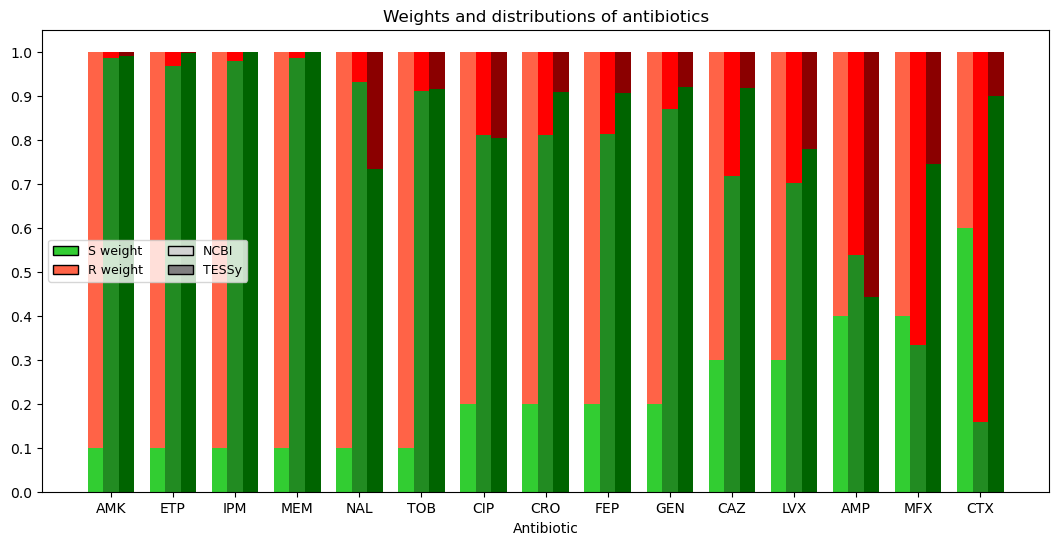

In [8]:
fig, ax = plt.subplots(figsize=(13, 6))
bar_width = 0.25
ind = np.arange(len(pivot_TESSy.index))
ax.bar(ind - bar_width, pivot_weights['S'], width=bar_width, color='limegreen')
ax.bar(ind - bar_width, pivot_weights['R'], width=bar_width, bottom=pivot_weights['S'], color='tomato')
ax.bar(ind, pivot_NCBI['S_share'], width=bar_width, color='forestgreen')
ax.bar(ind, pivot_NCBI['R_share'], width=bar_width, bottom=pivot_NCBI['S_share'], color='red')
ax.bar(ind + bar_width, pivot_TESSy['S_share'], width=bar_width, color='darkgreen')
ax.bar(ind + bar_width, pivot_TESSy['R_share'], width=bar_width, bottom=pivot_TESSy['S_share'], color='darkred')
ax.set_xticks(ind, pivot_TESSy.index)
ax.set_xlabel('Antibiotic')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_title("Weights and distributions of antibiotics")

S_weight = Rectangle((0,0),1,1,fc="limegreen", edgecolor = 'k')
R_weight = Rectangle((0,0),1,1,fc="tomato", edgecolor = 'k')
NCBI = Rectangle((0,0),1,1,fc="lightgrey", edgecolor = 'k')
TESSy = Rectangle((0,0),1,1,fc="grey", edgecolor = 'k')

handles = [S_weight, R_weight, NCBI, TESSy]
labels = ['S weight',  'R weight', 'NCBI', 'TESSy']

ax.legend(handles, labels, ncols=2, loc='center left', fontsize=9)
plt.show()